In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from pandas import set_option
from pandas import read_csv
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from matplotlib import pyplot
from scipy import interp

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import pandas as pd 


import numpy as np # linear algebra

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from  sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', True)
pd.set_option('max_colwidth', 80)

## Read Data

In [128]:
# TEAM: Set your path accordingly
# peter
root_path = "Course Data/Final/"

#kearey
#root_path = "fill in your path"

#nicole
#root_path = "fill in your path"


aisles = read_csv(root_path + "aisles.csv") 
departments = read_csv(root_path + "departments.csv") 
order_products__prior = read_csv(root_path + "order_products__prior.csv")
order_products__train = read_csv(root_path + "order_products__train.csv") 
orders = read_csv(root_path + "orders.csv") 
products = read_csv(root_path + "products.csv") 
sample_submission = read_csv(root_path +  "sample_submission.csv") 

In [129]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [130]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [131]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [132]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [133]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [134]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [135]:
sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


## Data Wrangling and Creating Features

In [91]:
# Remove users with 'test' eval_set. Their final orders are not labeled  with the detail.  Thus note usabel

In [92]:
exclude_user_id = orders[orders['eval_set'] == 'test'].user_id.unique()
exclude_user_id = pd.DataFrame({'user_id':exclude_user_id})

In [93]:
exclude_orders = pd.merge(orders, exclude_user_id, how='inner', on=['user_id'])
order_products__prior = (order_products__prior[~order_products__prior.order_id.isin(exclude_orders.order_id)])
orders = (orders[~orders.order_id.isin(exclude_orders.order_id)])

In [94]:
orders[orders['eval_set'] == 'test'].user_id.unique()

array([], dtype=int64)

In [95]:
# Buld our data set.

In [96]:
#user,item reorder count
data_t1  = pd.merge(order_products__prior, products, how='inner', on=['product_id'])
data_t1  = pd.merge(data_t1, orders, how='inner', on=['order_id'])
data_t1 = data_t1.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
data_t1.columns = ['user_id', 'product_id', 'reorder_count']


In [97]:
data_t2 = pd.merge(order_products__prior, orders, how='inner', on=['order_id'])
data_t2 = data_t2.groupby(['user_id'])['order_number'].max().reset_index()
data_t2.columns = ['user_id', 'prior_ordercount']
data_t2.head()

,user_id,prior_ordercount
0,1,10
1,2,14
2,5,4
3,7,20
4,8,3


In [98]:
# Add more features here based on prior data

In [99]:
data_prior =  pd.merge(data_t1, data_t2, how='inner', on=['user_id'])
data_prior.head()

,user_id,product_id,reorder_count,prior_ordercount
0,1,196,10,10
1,1,10258,9,10
2,1,10326,1,10
3,1,12427,10,10
4,1,13032,3,10


In [100]:
#reordered on 'train' orders
data_yesOrderLast  = pd.merge(order_products__train, products, how='inner', on=['product_id'])
data_yesOrderLast  = pd.merge(data_yesOrderLast, orders, how='inner', on=['order_id'])
data_yesOrderLast = data_yesOrderLast.groupby(['user_id', 'product_id', 'order_id'])['order_number'].count().reset_index()
data_yesOrderLast.columns = ['user_id', 'product_id', 'order_id', 'reordered']


In [101]:
data = pd.merge(data_prior, data_yesOrderLast, how='left', on=['user_id', 'product_id'])
data[['reordered']] = data[['reordered']].fillna(value=0)


In [102]:
data.head()

,user_id,product_id,reorder_count,prior_ordercount,order_id,reordered
0,1,196,10,10,1187899.0,1.0
1,1,10258,9,10,1187899.0,1.0
2,1,10326,1,10,NaN,0.0
3,1,12427,10,10,NaN,0.0
4,1,13032,3,10,1187899.0,1.0


In [103]:
data = pd.merge(data, products, how='left', on=['product_id'])
data = pd.merge(data, departments, how='left', on=['department_id'])
data = pd.merge(data, aisles, how='left', on=['aisle_id'])

In [104]:
data.head()

,user_id,product_id,reorder_count,prior_ordercount,order_id,reordered,product_name,aisle_id,department_id,department,aisle
0,1,196,10,10,1187899.0,1.0,Soda,77,7,beverages,soft drinks
1,1,10258,9,10,1187899.0,1.0,Pistachios,117,19,snacks,nuts seeds dried fruit
2,1,10326,1,10,NaN,0.0,Organic Fuji Apples,24,4,produce,fresh fruits
3,1,12427,10,10,NaN,0.0,Original Beef Jerky,23,19,snacks,popcorn jerky
4,1,13032,3,10,1187899.0,1.0,Cinnamon Toast Crunch,121,14,breakfast,cereal


In [105]:
# Test data

In [106]:
prior_data = pd.merge(order_products__prior, orders[orders['eval_set']=='prior'], how='inner', on=['order_id'])
test_data_temp = pd.merge(order_products__train, orders[orders['eval_set']=='train'], how='inner', on=['order_id'])

In [107]:

t1 = prior_data[prior_data['user_id'] == 202279].sort_values(by=['product_id', 'order_number'])
t2 = test_data_temp[test_data_temp['user_id'] == 202279].sort_values(by=['product_id', 'order_number'])

t3 = pd.concat([t1, t2])   

In [108]:
t3.sort_values(by=['product_id', 'order_number'])

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
9039452,1500071,432,3,0,202279,prior,2,4,13,20.0
17474453,2894949,1003,6,0,202279,prior,1,5,9,NaN
9039451,1500071,1003,2,1,202279,prior,2,4,13,20.0
16954779,2808715,1003,3,1,202279,prior,5,5,13,9.0
797834,132412,1003,2,1,202279,prior,6,5,9,30.0
14378516,2382766,1003,1,1,202279,prior,7,1,14,24.0
629999,104690,1003,1,1,202279,prior,8,6,10,30.0
429687,1050357,1003,2,1,202279,train,9,1,14,30.0
9039460,1500071,1819,11,0,202279,prior,2,4,13,20.0
7,2,1819,8,1,202279,prior,3,5,9,8.0


In [109]:
t4 = (data[data['user_id'] == 202279]).sort_values(by=['product_id'])

In [110]:
t4.head()

,user_id,product_id,reorder_count,prior_ordercount,order_id,reordered,product_name,aisle_id,department_id,department,aisle
8314791,202279,432,1,8,NaN,0.0,Vanilla Almond Breeze Almond Milk,91,16,dairy eggs,soy lactosefree
8314792,202279,1003,6,8,1050357.0,1.0,Organic Turkey Bone Broth,5,13,pantry,marinades meat preparation
8314793,202279,1819,2,8,NaN,0.0,All Natural No Stir Creamy Almond Butter,88,13,pantry,spreads
8314794,202279,2086,1,8,NaN,0.0,Sustainably Soft Bath Tissue,54,17,household,paper goods
8314795,202279,2154,1,8,NaN,0.0,Homestyle Savory Chicken Bone Broth,69,15,canned goods,soup broth bouillon


In [111]:
# Set types

In [112]:
data['aisle_id'] = data['aisle_id'].astype('int')
data['department_id'] = data['department_id'].astype('int')
data['reordered'] = data['reordered'].astype('int')


## Create Training KFolds Set and Holdout

In [113]:
# Split data into train and hold out. For now use a small set to quickly run the experiments.
trainUserIDs = orders[orders['eval_set']=='prior'].user_id.unique()
userTrain, otherData = train_test_split(trainUserIDs,test_size = 0.99,  random_state=42)
#userTrain, otherData = train_test_split(trainUserIDs,test_size = 0.75,  random_state=42)
userTrainDF = pd.DataFrame({'user_id':userTrain})


trainData = pd.merge(data, userTrainDF[['user_id']], how='inner', on=['user_id'])


userTest, notUsed = train_test_split(otherData, test_size = 0.99,  random_state=42)
#userTest, notUsed = train_test_split(otherData, test_size = 0.7,  random_state=42)
userTestDF = pd.DataFrame({'user_id':userTest})

testData = pd.merge(data, userTestDF[['user_id']], how='inner', on=['user_id'])


In [114]:
trainData.shape

(85683, 11)

In [115]:
trainData.dtypes

user_id               int64
product_id            int64
reorder_count         int64
prior_ordercount      int64
order_id            float64
reordered             int32
product_name         object
aisle_id              int32
department_id         int32
department           object
aisle                object
dtype: object

In [116]:
trainData.shape

(85683, 11)

## Exploratory Data Analysis

## Feature Selection

In [117]:

print(trainData.columns)

Index(['user_id', 'product_id', 'reorder_count', 'prior_ordercount',
       'order_id', 'reordered', 'product_name', 'aisle_id', 'department_id',
       'department', 'aisle'],
      dtype='object')


In [118]:
# TEAM: Experiment Models
selectFeatures = ['product_id',  'aisle_id', 'department_id', 'prior_ordercount', 'reorder_count']
outputVariable = ['reordered']




In [119]:
X = trainData[selectFeatures]
Y = trainData[outputVariable]


In [120]:
X.head()

,product_id,aisle_id,department_id,prior_ordercount,reorder_count
0,49,14,20,20,1
1,2597,19,13,20,2
2,3469,59,15,20,9
3,4461,19,13,20,1
4,5024,59,15,20,4


In [121]:
Y.dtypes

reordered    int32
dtype: object

## Model Comparision, ROC

In [122]:
# TEAM: Experiment Models
models = []

models.append(('Dummy', DummyClassifier(strategy='most_frequent',random_state=0)))
#models.append(('RandomForest1', RandomForestClassifier(n_estimators=100, max_depth = 2, random_state=42)))
#models.append(('RandomForest2', RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)))
#models.append(('RandomForest3', RandomForestClassifier(n_estimators=100, max_depth = 4, random_state=42)))
#models.append(('RandomForest4', RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)))
#models.append(('RandomForest5', RandomForestClassifier(n_estimators=100, max_depth = 6, random_state=42)))
models.append(('RandomForest', RandomForestClassifier(n_estimators=100, max_depth = 3, random_state=42)))
#models.append(('RandomForest7', RandomForestClassifier(n_estimators=100, max_depth = 8, random_state=42)))
#models.append(('RandomForest8', RandomForestClassifier(n_estimators=100, max_depth = 9, random_state=42)))
models.append(('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, algorithm="SAMME.R", learning_rate=.75,random_state=42)))
models.append(('XGBoost',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
'''
models.append(('XGBoost2',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost3',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost4',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost5',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
models.append(('XGBoost6',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))
'''

"\nmodels.append(('XGBoost2',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,\n min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost3',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=6,\n min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost4',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost5',XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=4,\n min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)))\nmodels.append(('XGBoost6',XGBClassifier(learning_rate =0.1, n

C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dummy: 0.906773 (0.004174)
RandomForest: 0.906773 (0.004174)


C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost: 0.909037 (0.004199)


C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoost: 0.909947 (0.004522)


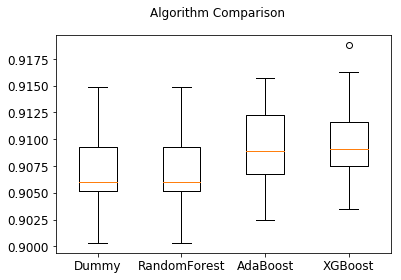

In [123]:
from sklearn.utils import check_X_y

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    #Bug with dummy. Suggested by https://github.com/scikit-learn/scikit-learn/issues/10786
    X_converted, y_converted = check_X_y(X=X, y=Y)
    cv_results = cross_val_score(model, X_converted, y_converted, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
## boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [124]:

#https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv 
X_converted, y_converted = check_X_y(X=X, y=Y)

mean_fpr = dict()
mean_tpr = dict()
mean_auc = dict()

for name, model in models:
    tprs = []
    aucs = []
    mean_fpr[name] = np.linspace(0,1,100)
    i = 1
    kfold = KFold(n_splits=10, random_state=7)

    for train,test in kfold.split(X_converted,y_converted):
        prediction = model.fit(X_converted[train],y_converted[train]).predict_proba(X_converted[test])
        fpr, tpr, thres = roc_curve(y_converted[test], prediction[:, 1])
        tprs.append(interp(mean_fpr[name], fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i= i+1

    mean_tpr[name] = np.mean(tprs, axis=0)
    mean_auc[name] = auc(mean_fpr[name], mean_tpr[name])
    #model.fit(X_converted, y_converted)
    if (name == 'Dummy'):
        model.fit(X_converted, y_converted)
    else:
        model.fit(X, Y)


C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Peter\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

auc Dummy:0.5
auc RandomForest:0.7624223420367529
auc AdaBoost:0.7753215403200777
auc XGBoost:0.7760975220280748


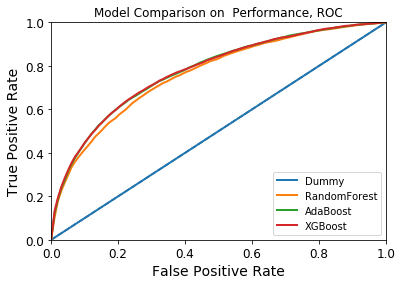

In [125]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for name, model in models:
    ax.plot(mean_fpr[name], mean_tpr[name], linewidth=2, label = name)
    print("auc " + name + ":" + str(mean_auc[name]))

    
plt.title('Model Comparison on  Performance, ROC')
plt.legend(loc="best")
plt.show()


## F1 Score on Hold out Set

In [126]:
X_test = testData[selectFeatures]
y_test = testData[outputVariable]

for name, model in models:
    y_pred = model.predict(X_test)
    print("model name:" + name)
    print("F1 score :" + str(f1_score(y_test, y_pred, average="macro")))
    print("Precision score:" + str(precision_score(y_test, y_pred, average="macro")))
    print("Recall score:" + str(recall_score(y_test, y_pred, average="macro")))
    
    unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
    print("Frequency of unique values of the predicated array:")
    print(np.asarray((unique_elements, counts_elements)))
    print("")



model name:Dummy
F1 score :0.4737542853099895
Precision score:0.4501265018272486
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [81817]]



C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model name:RandomForest
F1 score :0.4737542853099895
Precision score:0.4501265018272486
Recall score:0.5
Frequency of unique values of the predicated array:
[[    0]
 [81817]]



C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model name:AdaBoost
F1 score :0.5182583733445798
Precision score:0.7732652635842023
Recall score:0.5221895752682915
Frequency of unique values of the predicated array:
[[    0     1]
 [81216   601]]

model name:XGBoost
F1 score :0.5683360614544845
Precision score:0.763101798975623
Recall score:0.5514545917092352
Frequency of unique values of the predicated array:
[[    0     1]
 [80354  1463]]



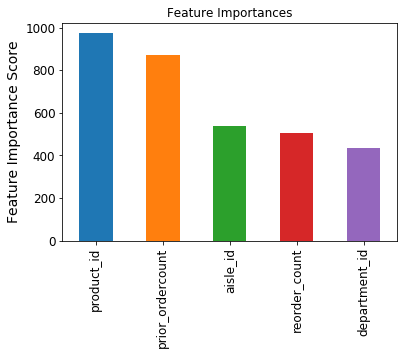

In [127]:
for name, model in models:
    if (name == 'XGBoost'):
        feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')